In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Last velocity: -72.226879643049


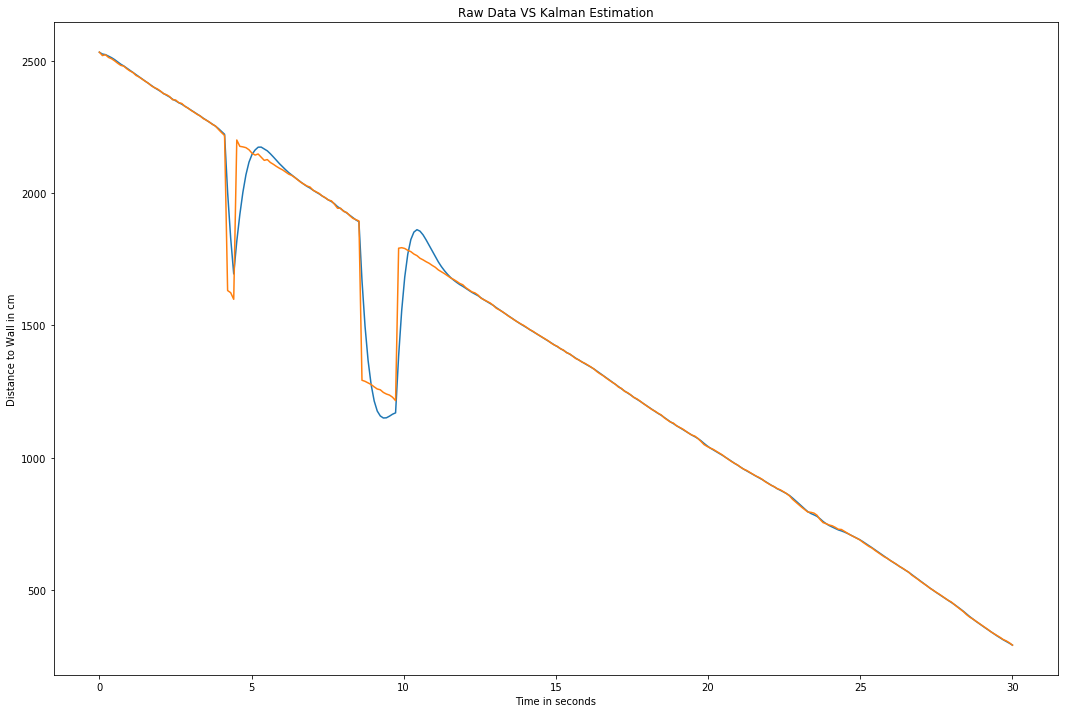

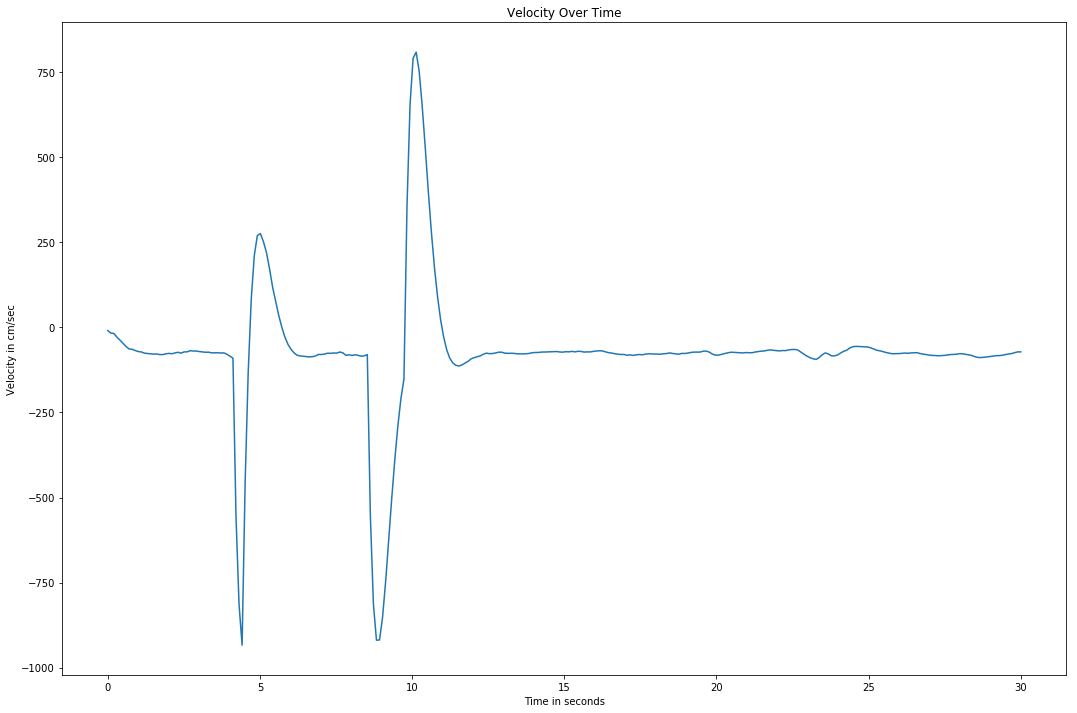

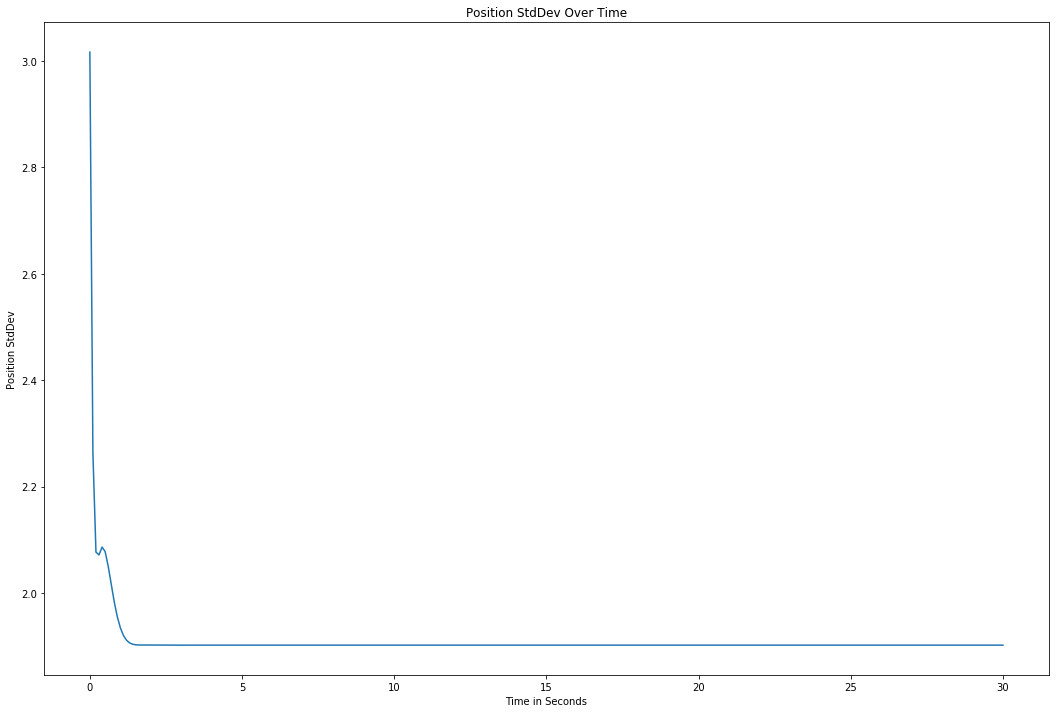

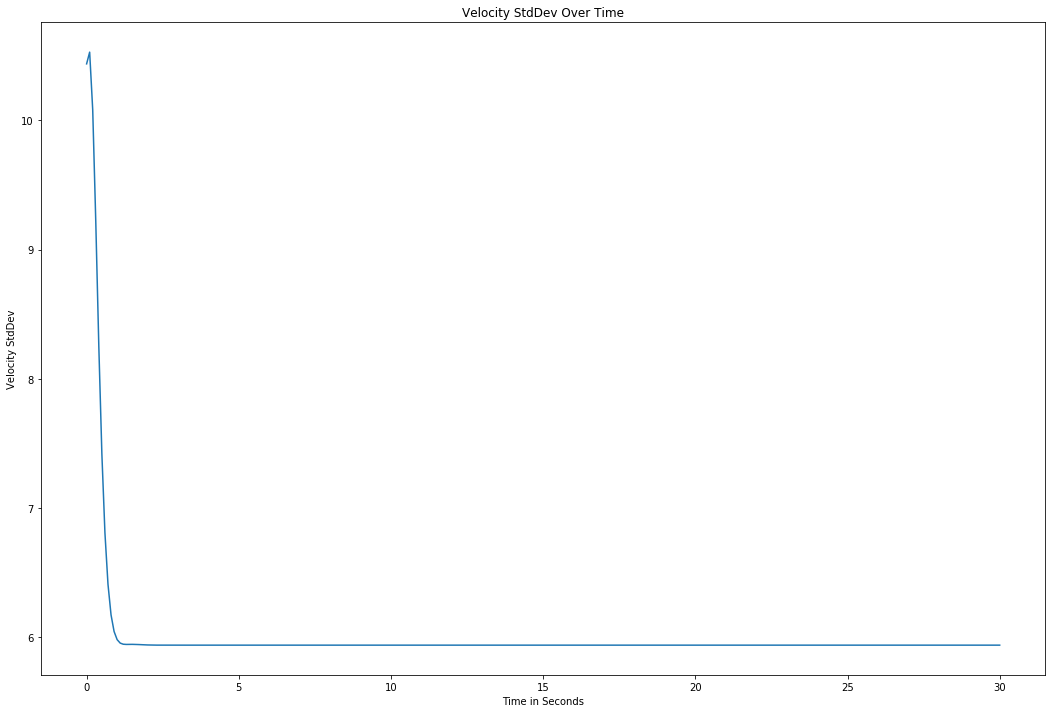

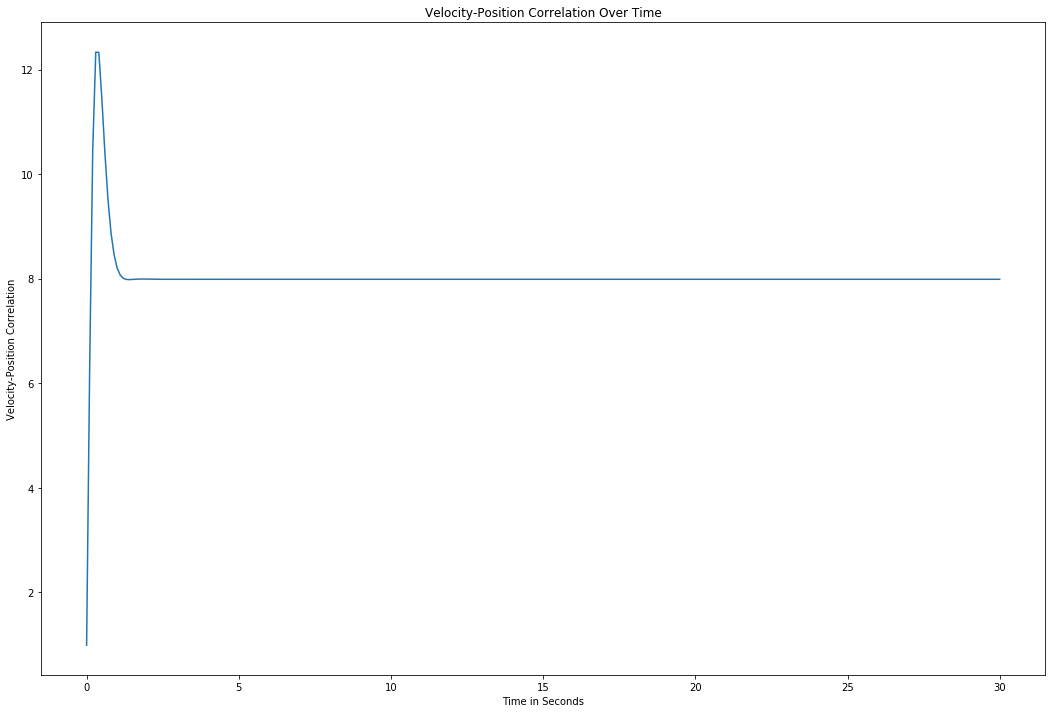

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from kalman import predict, update, dot3

plt.rcParams["figure.figsize"] = [18, 12]

wall_file = "RBE500-F17-100ms-Constant-Vel.csv"

with open(wall_file, "r") as f:
    data = f.read().split('\n')[:-1]
    data = [int(v) for v in data]

# Setup initial variables and matrices
initial_pos = 2530
velocity = -10.0
variance = 10.0
dt = 0.1
F = np.array([[1., dt],
              [0., 1.]])
P = np.array([[100., 0],
              [0, 100.0]])
H = np.array([[1., 0.]])
R = np.array([[variance]])
Q = np.array([[0.1, 1], [1, 10.]])
x = np.array([initial_pos, velocity]).T

predicted_xs = []

def run(x, P, R=0, Q=0, dt=0.1, 
        zs=None):
    # run the kalman filter and store the results
    xs, cov = [], []
    for z in zs:
        x, P = predict(x, P, F, Q)
        x, P = update(x, P, z, R, H)
        xs.append(x)
        cov.append(P)

    xs, cov = np.array(xs), np.array(cov)
    return xs, cov

time_values = np.linspace(0, dt * len(data), len(data))

est_x, est_P = run(x, P, R, Q, dt, data)
est_pos = [v[0] for v in est_x]
est_vel = [v[1] for v in est_x]
print("Last velocity: {}".format(est_vel[-1]))
plt.plot(time_values, est_pos)
plt.plot(time_values, data)
plt.xlabel("Time in seconds")
plt.ylabel("Distance to Wall in cm")
plt.title("Raw Data VS Kalman Estimation")
plt.show()

plt.plot(time_values, est_vel)
plt.xlabel("Time in seconds")
plt.ylabel("Velocity in cm/sec")
plt.title("Velocity Over Time")
plt.show()

pos_var = [p[0][0]**0.5 for p in est_P]
vel_var = [p[1][1]**0.5 for p in est_P]
pos_vel_corr = [p[0][1] for p in est_P]
plt.plot(time_values, pos_var)
plt.ylabel("Position StdDev")
plt.xlabel("Time in Seconds")
plt.title("Position StdDev Over Time")
plt.show()

plt.plot(time_values, vel_var)
plt.ylabel("Velocity StdDev")
plt.xlabel("Time in Seconds")
plt.title("Velocity StdDev Over Time")
plt.show()

plt.plot(time_values, pos_vel_corr)
plt.ylabel("Velocity-Position Correlation")
plt.xlabel("Time in Seconds")
plt.title("Velocity-Position Correlation Over Time")
plt.show()

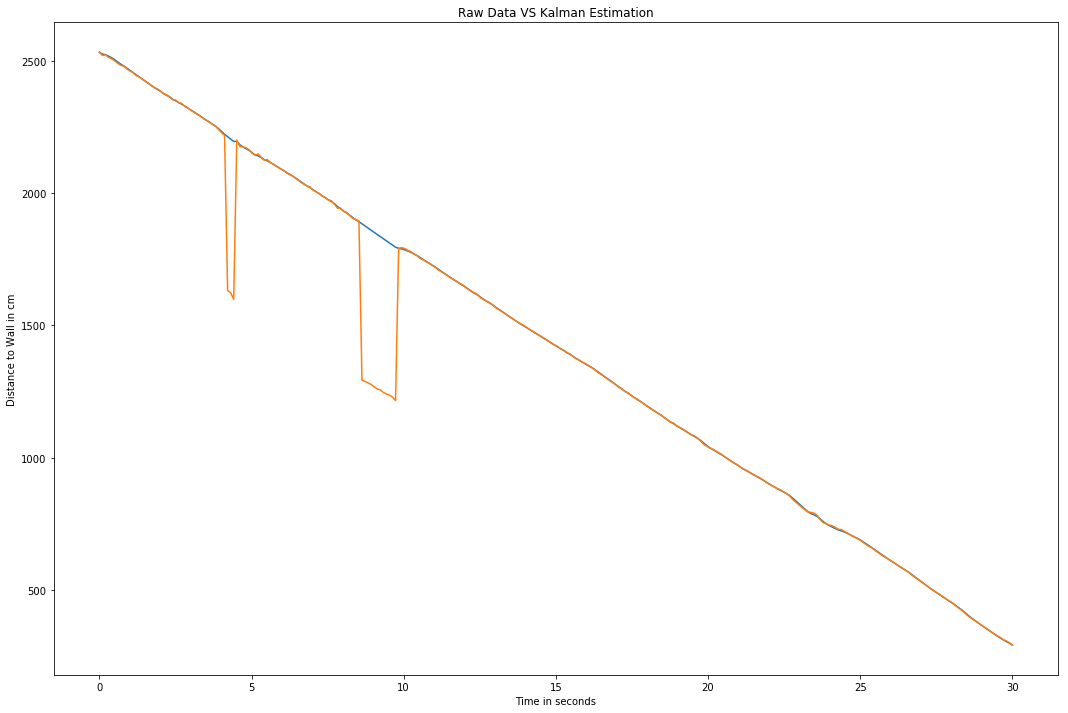

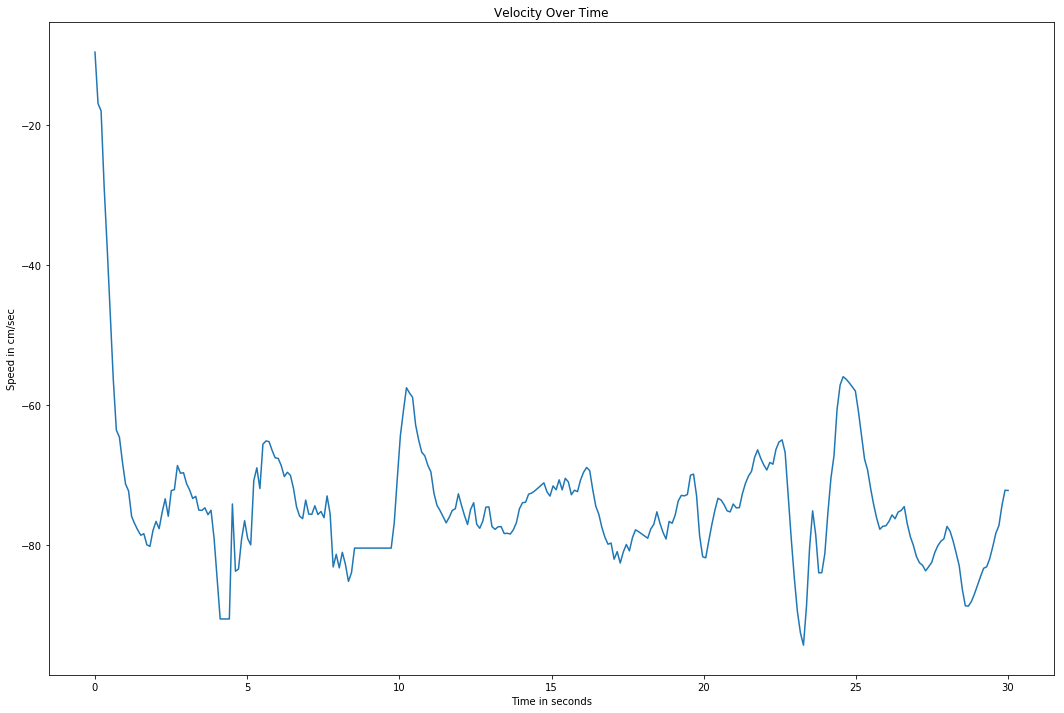

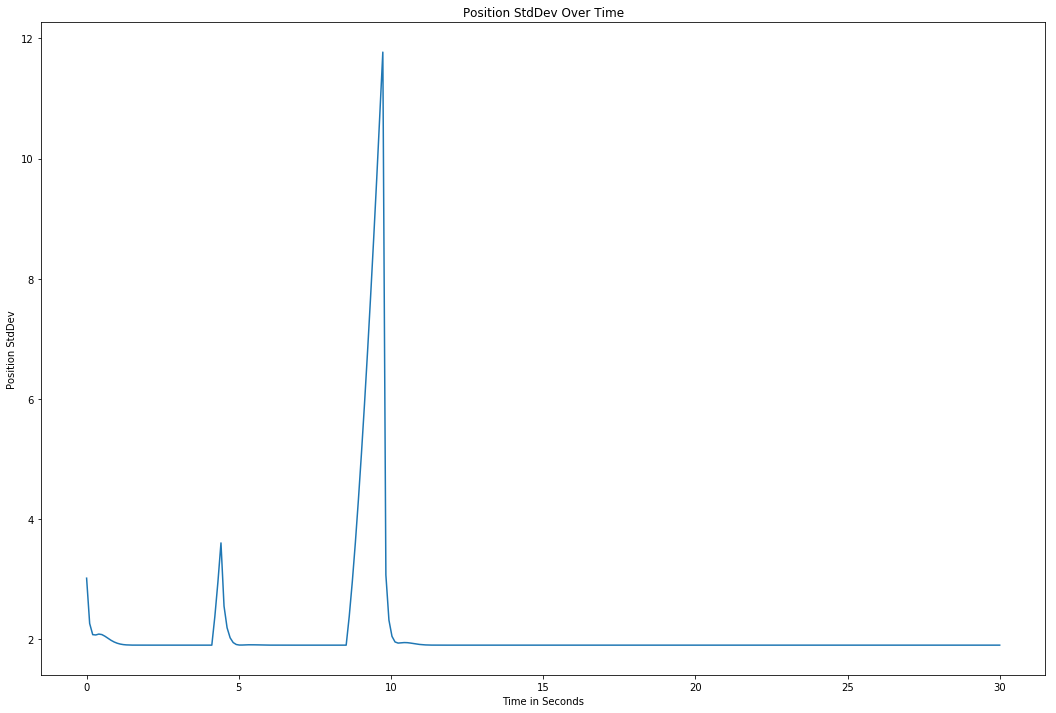

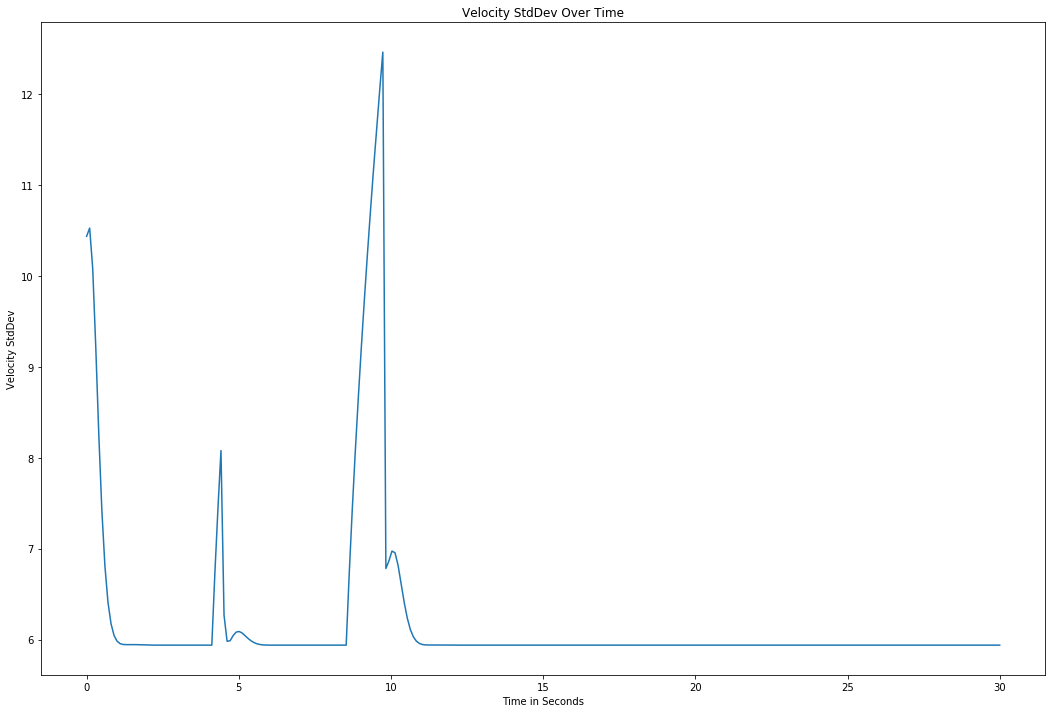

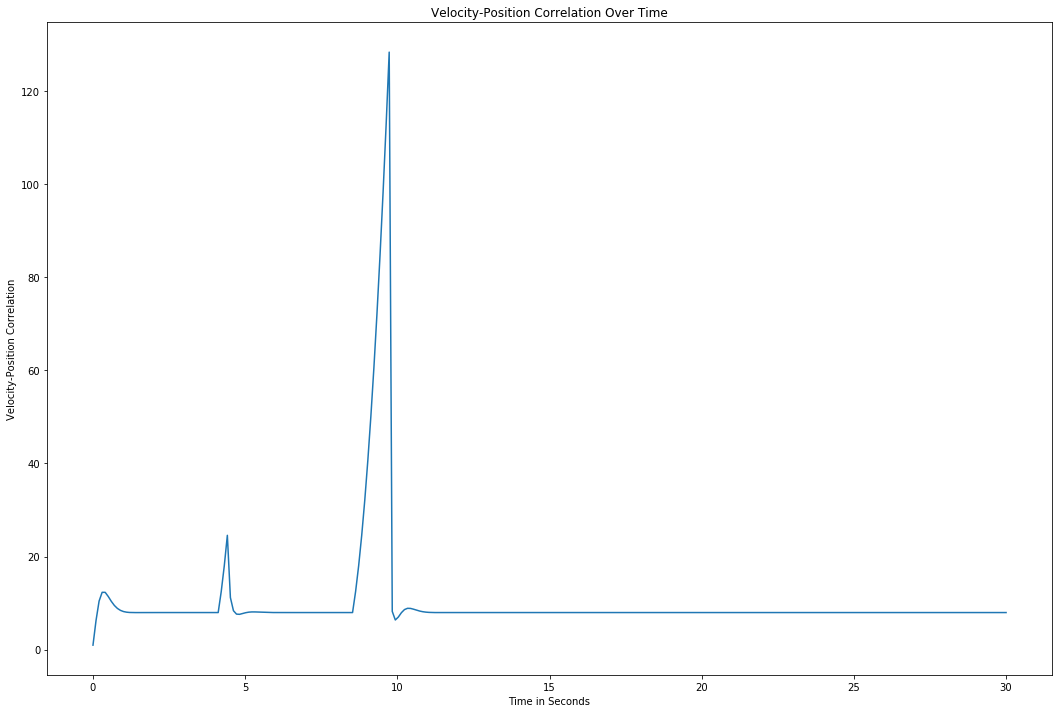

In [4]:
# Setup initial variables and matrices
initial_pos = 2530
velocity = -10.0
variance = 10.0
dt = 0.1
F = np.array([[1., dt],
              [0., 1.]])
P = np.array([[100., 0],
              [0, 100.0]])
H = np.array([[1., 0.]])
R = np.array([[variance]])
Q = np.array([[0.1, 1], [1, 10.]])
x = np.array([initial_pos, velocity]).T

predicted_xs = []

def run(x, P, R=0, Q=0, dt=0.1, zs=None):
    # run the kalman filter and store the results
    xs, cov = [], []
    for z in zs:
        x, P = predict(x, P, F, Q)
        S = dot3(H, P, H.T) + R
        n = z - np.dot(H, x)
        d = n*n / S
        
        if d < 9.0:
            x, P = update(x, P, z, R, H)

        xs.append(x)
        cov.append(P)

    xs, cov = np.array(xs), np.array(cov)
    return xs, cov

time_values = np.linspace(0, dt * len(data), len(data))

est_x, est_P = run(x, P, R, Q, dt, data)
est_pos = [v[0] for v in est_x]
est_vel = [v[1] for v in est_x]
plt.plot(time_values, est_pos)
plt.plot(time_values, data)
plt.xlabel("Time in seconds")
plt.ylabel("Distance to Wall in cm")
plt.title("Raw Data VS Kalman Estimation")
plt.show()

plt.plot(time_values, est_vel)
plt.xlabel("Time in seconds")
plt.ylabel("Speed in cm/sec")
plt.title("Velocity Over Time")
plt.show()

pos_var = [p[0][0]**0.5 for p in est_P]
vel_var = [p[1][1]**0.5 for p in est_P]
pos_vel_corr = [p[0][1] for p in est_P]
plt.plot(time_values, pos_var)
plt.ylabel("Position StdDev")
plt.xlabel("Time in Seconds")
plt.title("Position StdDev Over Time")
plt.show()

plt.plot(time_values, vel_var)
plt.ylabel("Velocity StdDev")
plt.xlabel("Time in Seconds")
plt.title("Velocity StdDev Over Time")
plt.show()

plt.plot(time_values, pos_vel_corr)
plt.ylabel("Velocity-Position Correlation")
plt.xlabel("Time in Seconds")
plt.title("Velocity-Position Correlation Over Time")
plt.show()

Mean: 1390.2133333333334


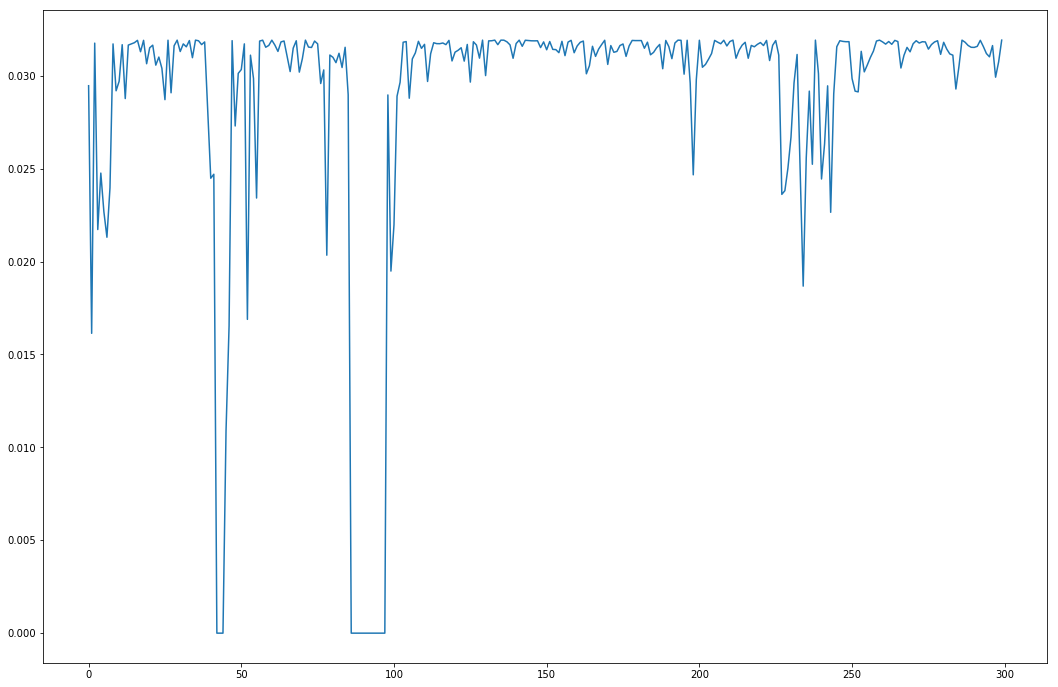

In [50]:
def gaussian(x, mu, sig):
    return (1/(np.sqrt(2 * np.pi * np.power(sig, 2.)))) * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

# Setup initial variables and matrices
initial_pos = 2530
velocity = -10.0
variance = 10.0
dt = 0.1
F = np.array([[1., dt],
              [0., 1.]])
P = np.array([[100., 0],
              [0, 100.0]])
H = np.array([[1., 0.]])
R = np.array([[variance]])
Q = np.array([[0.1, 1], [1, 10.]])
x = np.array([initial_pos, velocity]).T

object_c = 0.2
wall_c = 0.8
lamb = 0.0005

def object_pdf(z):
    return object_c * lamb * np.exp(-lamb * z)

def wall_pdf(z, wall_mean):
    return wall_c * gaussian(z, wall_mean, variance)


readings_mean = np.mean(data)
print("Mean: {}".format(readings_mean))

wall_pdf_vals = []
obj_pdf = []
xs = []
low_wall = []
high_obj = []
for z in data:
    x, P = predict(x, P, F, Q)

    wall_pdf_vals.append(wall_pdf(z, x[0]))
    obj_pdf.append(object_pdf(z))

    if obj_pdf[-1] < wall_pdf_vals[-1]:
        x, P = update(x, P, z, R, H)
    else:
        high_obj.append(obj_pdf[-1])
        low_wall.append(wall_pdf_vals[-1])

    xs.append(x[0])
    
def run(x=(0.,0.), P=500, R=0, Q=0, dt=0.1, 
    zs=None):
# run the kalman filter and store the results
xs, cov = [], []
for z in zs:
    x, P = predict(x, P, F, Q)
    S = dot3(H, P, H.T) + R
    n = z - np.dot(H, x)
    d = n*n / S

    if d < 9.0:
        x, P = update(x, P, z, R, H)

    xs.append(x)
    cov.append(P)

xs, cov = np.array(xs), np.array(cov)
return xs, cov

plt.plot(wall_pdf_vals)
#plt.plot(obj_pdf)
#plt.plot(xs)
#plt.plot(high_obj)
#plt.plot(low_wall)
plt.show()